# ANALISIS DE REGRESION LOGÌSTICA

Librerías a utilizar

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, accuracy_score
from sklearn import metrics

Base de datos

In [2]:
df = pd.read_csv('BD_Loan.csv', delimiter= ',')
df.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Estructura de los datos
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [4]:
# Cantidad de los datos
df.shape

(614, 13)

In [5]:
## Validamos el número de clientes únicos en la base
len(df.Loan_ID.unique())

614

# Exploraciòn de la data

Funciones

In [6]:
## Calcula los porcentajes de missings por variable

def fx_porc_missings(data, only_missings = False):

    df_vars_missings = pd.concat([pd.DataFrame(data.isnull().sum(), columns = ['n_nulos']),
           pd.DataFrame(100*data.isnull().sum()/len(data), columns = ['%Total'])], axis = 1)
    if only_missings:
        return(df_vars_missings[df_vars_missings["n_nulos"]!=0])
    else:
        return(df_vars_missings)

In [7]:
## Estructura de los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
# Número de datos ausentes por variable
# ==============================================================================
df.isna().sum().sort_values()

Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
Married               3
Gender               13
Loan_Amount_Term     14
Dependents           15
LoanAmount           22
Self_Employed        32
Credit_History       50
dtype: int64

Variable Objetivo

In [9]:
# Frecuencia de la variable objetivo
df.Loan_Status.value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [10]:
df.Loan_Status.value_counts()/df.shape[0]

Loan_Status
Y    0.687296
N    0.312704
Name: count, dtype: float64

In [11]:
## Convertir variable
df['Target'] = df['Loan_Status'].replace({'N': 0,'Y': 1})

In [12]:
df = df.drop(['Loan_Status'], axis = 1)

<ipython-input-15-cd145fc54814>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x ='Target',data=df,palette ='spring')


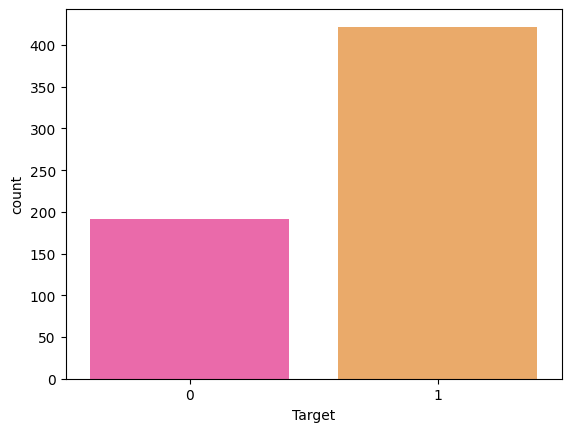

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x ='Target',data=df,palette ='spring')
plt.savefig('Préstamo_Hipotecario.png', bbox_inches='tight')

In [16]:
# Guardamos los identificadores de cliente y los excluimos del análisis de variables
df_index = df[['Loan_ID','Target']]
df = df.drop(['Loan_ID'], axis = 1)

Variables numèricas

In [17]:
numericas= df.select_dtypes(include=['float64', 'int'])

In [18]:
# Variables numéricas
# ==============================================================================
# df.select_dtypes(include=['float64', 'int']).describe()
numericas.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Target
count,614.000000,614.000000,592.000000,600.00000,564.000000,614.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,0.687296
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,0.463973
min,150.000000,0.000000,9.000000,12.00000,0.000000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,0.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,1.000000


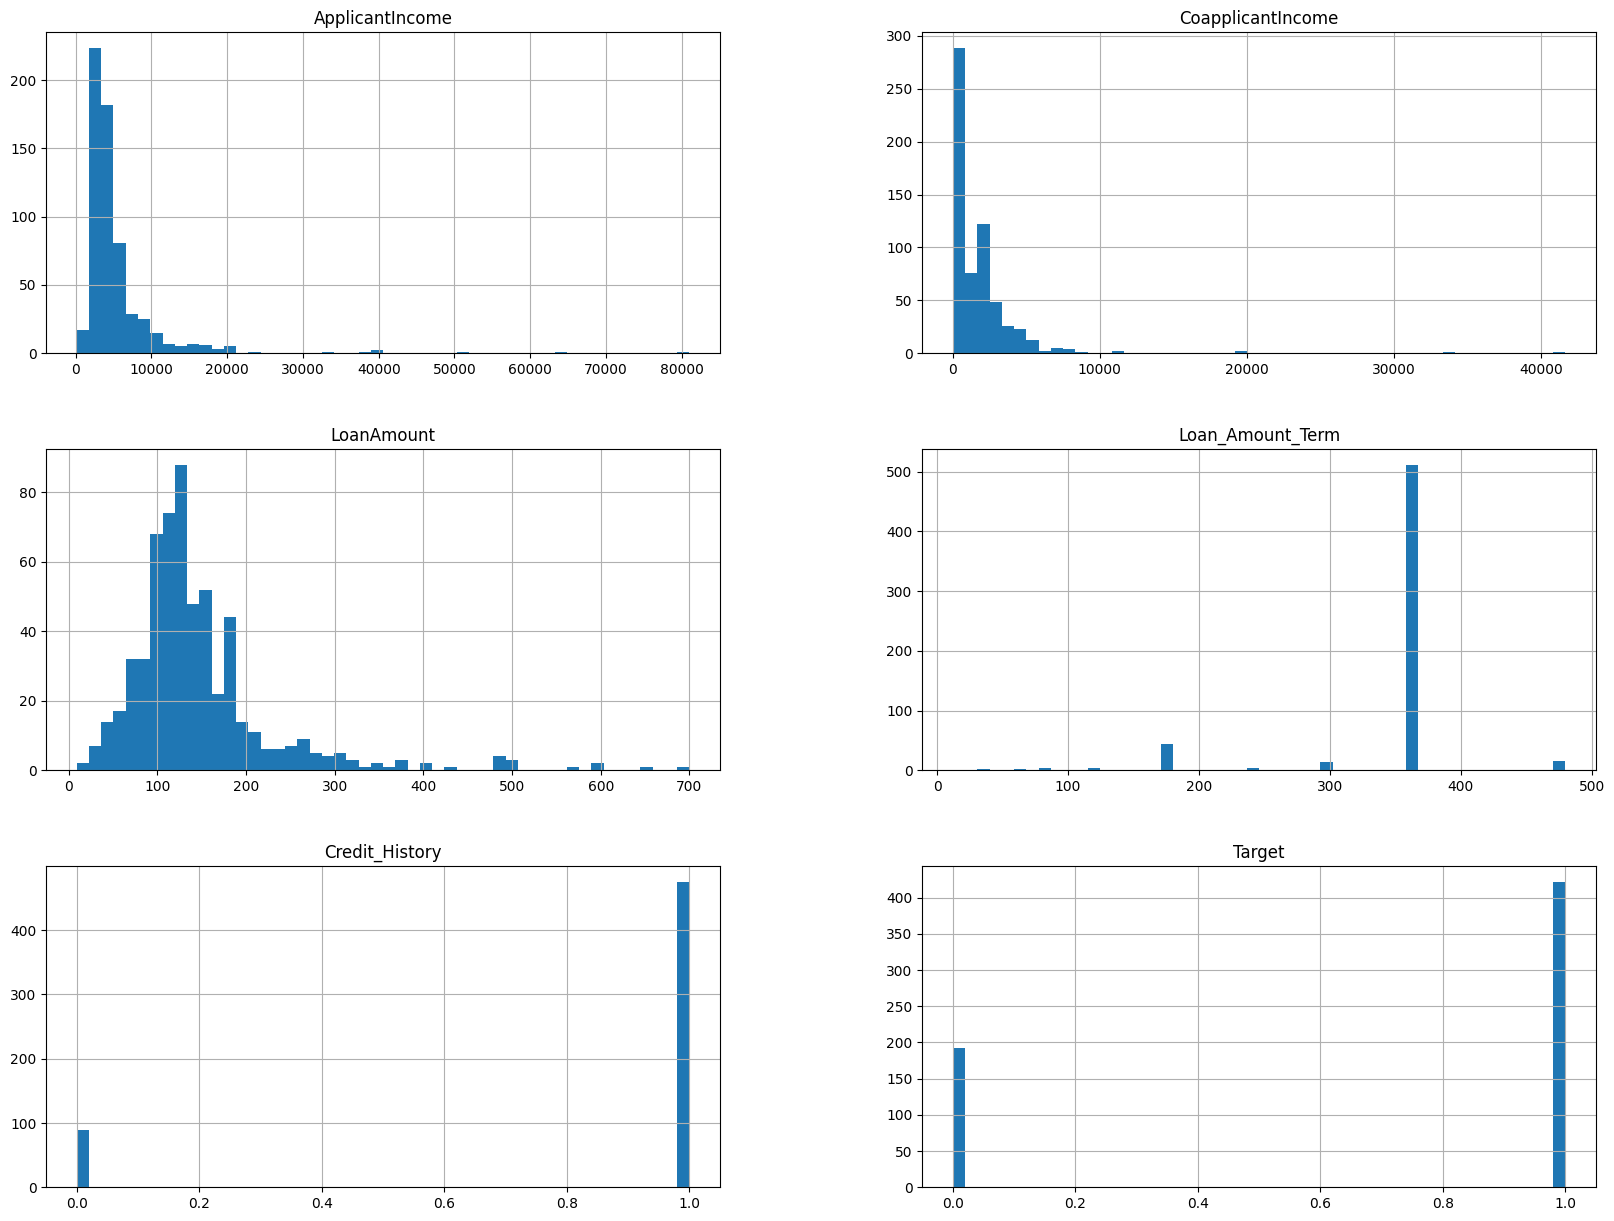

In [19]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
numericas.hist(bins=50,figsize=(20,15))
plt.show()

In [20]:
# Valores observados
# ==============================================================================
df.Credit_History.value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [21]:
## Missing de Variables
variables_perdidos = fx_porc_missings(numericas, only_missings = True)
#variables_perdidos.head()
variables_perdidos

,n_nulos,%Total
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130
Credit_History,50,8.143322


In [22]:
#para la muestra se va considerr 60%
variables_perdidos[variables_perdidos['%Total'] > 60].index.tolist()

[]

In [23]:
## Imputar con la mediana
for column in numericas:
    df[column] = df[column].fillna(df[column].median())

In [24]:
# Se convierte la variable a tipo string
# ==============================================================================
df.Credit_History = df.Credit_History.astype("str")

Variables Cualitativas

In [25]:
categoricas = df.select_dtypes(include=['object','category'])

In [26]:
# Variables cualitativas (tipo object)
# ==============================================================================
categoricas.describe()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,2,3
top,Male,Yes,0,Graduate,No,1.0,Semiurban
freq,489,398,345,480,500,525,233


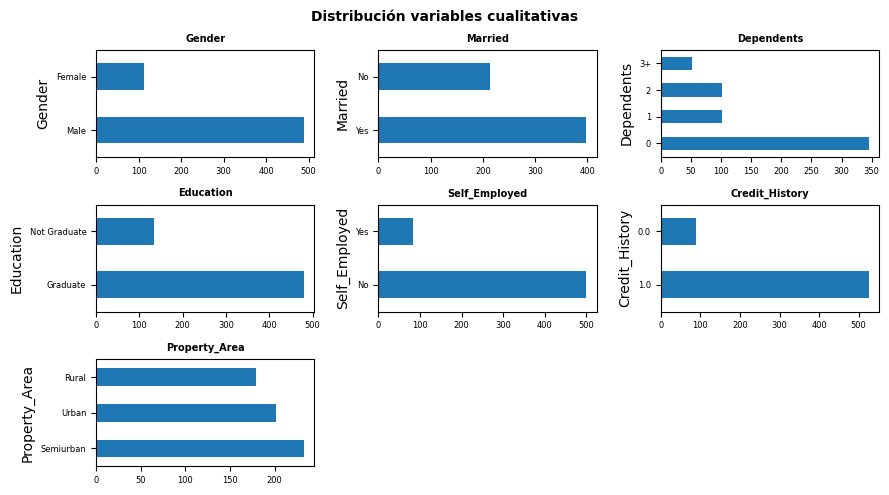

In [27]:
# Gráfico para cada variable cualitativa
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_object = df.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    df[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables cualitativas',
             fontsize = 10, fontweight = "bold");

In [28]:
# Recodificando y convirtiendo las variables de acuerdo a nuestro criterio
df['Dependents'] = df['Dependents'].replace({'0': 1,'1': 2, '2': 3, '3+': 4})

In [29]:
## Missing de Variables
variables_perdidos = fx_porc_missings(categoricas, only_missings = True)
#variables_perdidos.head()
variables_perdidos

,n_nulos,%Total
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Self_Employed,32,5.211726


In [30]:
#Imputar variables
for column in categoricas:
    df[column] = df[column].fillna(df[column].mode()[0])

Revisando relación con la variable Target

In [31]:
df[['Gender', 'Target']].groupby(['Gender'], as_index=False).agg(['count','sum','mean'])

Target               
        count  sum      mean
Gender                      
Female    112   75  0.669643
Male      502  347  0.691235

La variable Gender si discrimina el comportamiento del Target

In [32]:
df[['Married', 'Target']].groupby(['Married'], as_index=False).agg(['count','sum','mean'])

Target               
         count  sum      mean
Married                      
No         213  134  0.629108
Yes        401  288  0.718204

La Variable Married si discrimina el comportamiento del Target

In [33]:
df[['Education', 'Target']].groupby(['Education'], as_index=False).agg(['count','sum','mean'])

Target               
              count  sum      mean
Education                         
Graduate        480  340  0.708333
Not Graduate    134   82  0.611940

La variable Education si discrimina el comportamiento del Target

In [34]:
df[['Self_Employed', 'Target']].groupby(['Self_Employed'], as_index=False).agg(['count','sum','mean'])

Target               
               count  sum      mean
Self_Employed                      
No               532  366  0.687970
Yes               82   56  0.682927

La variables Self Employed no discrimina el comportamiento del Target

In [35]:
df[['Credit_History', 'Target']].groupby(['Credit_History'], as_index=False).agg(['count','sum','mean'])

Target               
                count  sum      mean
Credit_History                      
0.0                89    7  0.078652
1.0               525  415  0.790476

La variable Credit History si discrimina el comportamiento del Target

In [36]:
df[['Property_Area', 'Target']].groupby(['Property_Area'], as_index=False).agg(['count','sum','mean'])

Target               
               count  sum      mean
Property_Area                      
Rural            179  110  0.614525
Semiurban        233  179  0.768240
Urban            202  133  0.658416

La variable Property Area si discrimina el comportamiento del Target



Del total de variables revisadas nos quedamos con:

*   Gender
*   Married
*   Education
*   Credit_History
*   Property_Area

Eliminamos la variable no seleccionada

In [37]:
df = df.drop(['Self_Employed'], axis = 1)

In [38]:
## Cantidad de Categorías por Variable
variables_str  = df.select_dtypes(include = ['object','category']).columns.tolist()
for var in variables_str:
    print('N de ', var,':',df[var].nunique())

N de  Gender : 2
N de  Married : 2
N de  Education : 2
N de  Credit_History : 2
N de  Property_Area : 3


In [39]:
categorical=pd.get_dummies(df[variables_str],columns=variables_str,drop_first=True)
categorical.columns = ['Gender','Married','Education','Credit_History','Property_Area_1','Property_Area_2']
categorical

,Gender,Married,Education,Credit_History,Property_Area_1,Property_Area_2
0,True,False,False,True,False,True
1,True,True,False,True,False,False
2,True,True,False,True,False,True
3,True,True,True,True,False,True
4,True,False,False,True,False,True
...,...,...,...,...,...,...
609,False,False,False,True,False,False
610,True,True,False,True,False,False
611,True,True,False,True,False,True
612,True,True,False,True,False,True


Creación y Transformación de Variables

In [40]:
# Feature Engineering
# Creación de variables a partir de las definidas
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LoanAmount_Log'] = round(np.log(df['LoanAmount']+1),2)
df['AmountxTerm']=round(df['LoanAmount']/df['Loan_Amount_Term'],2)

In [41]:
df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Target,TotalIncome,LoanAmount_Log,AmountxTerm
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,1.744300,5403.459283,1621.245798,145.752443,342.410423,0.687296,7024.705081,4.866173,0.473844
std,1.009623,6109.041673,2926.248369,84.107233,64.428629,0.463973,6458.663872,0.491101,0.511007
min,1.000000,150.000000,0.000000,9.000000,12.000000,0.000000,1442.000000,2.300000,0.020000
25%,1.000000,2877.500000,0.000000,100.250000,360.000000,0.000000,4166.000000,4.620000,0.290000
50%,1.000000,3812.500000,1188.500000,128.000000,360.000000,1.000000,5416.500000,4.860000,0.360000
75%,2.000000,5795.000000,2297.250000,164.750000,360.000000,1.000000,7521.750000,5.110000,0.510000
max,4.000000,81000.000000,41667.000000,700.000000,480.000000,1.000000,81000.000000,6.550000,9.250000


In [42]:
numericas = df.select_dtypes(include=('int64','float64'))
numericas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dependents         614 non-null    float64
 1   ApplicantIncome    614 non-null    int64  
 2   CoapplicantIncome  614 non-null    float64
 3   LoanAmount         614 non-null    float64
 4   Loan_Amount_Term   614 non-null    float64
 5   Target             614 non-null    int64  
 6   TotalIncome        614 non-null    float64
 7   LoanAmount_Log     614 non-null    float64
 8   AmountxTerm        614 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 43.3 KB


In [43]:
preprocessed_data = pd.merge(numericas, categorical, left_index=True, right_index=True)
preprocessed_data.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Target,TotalIncome,LoanAmount_Log,AmountxTerm,Gender,Married,Education,Credit_History,Property_Area_1,Property_Area_2
0,1.0,5849,0.0,128.0,360.0,1,5849.0,4.86,0.36,True,False,False,True,False,True
1,2.0,4583,1508.0,128.0,360.0,0,6091.0,4.86,0.36,True,True,False,True,False,False
2,1.0,3000,0.0,66.0,360.0,1,3000.0,4.20,0.18,True,True,False,True,False,True
3,1.0,2583,2358.0,120.0,360.0,1,4941.0,4.80,0.33,True,True,True,True,False,True
4,1.0,6000,0.0,141.0,360.0,1,6000.0,4.96,0.39,True,False,False,True,False,True


In [44]:
# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

In [45]:
corr_matrix = preprocessed_data.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
34,LoanAmount,LoanAmount_Log,0.898047,0.898047
66,LoanAmount_Log,LoanAmount,0.898047,0.898047
15,ApplicantIncome,TotalIncome,0.893037,0.893037
55,TotalIncome,ApplicantIncome,0.893037,0.893037
33,LoanAmount,TotalIncome,0.620316,0.620316
57,TotalIncome,LoanAmount,0.620316,0.620316
12,ApplicantIncome,LoanAmount,0.565181,0.565181
28,LoanAmount,ApplicantIncome,0.565181,0.565181
61,TotalIncome,LoanAmount_Log,0.507210,0.507210
69,LoanAmount_Log,TotalIncome,0.507210,0.507210


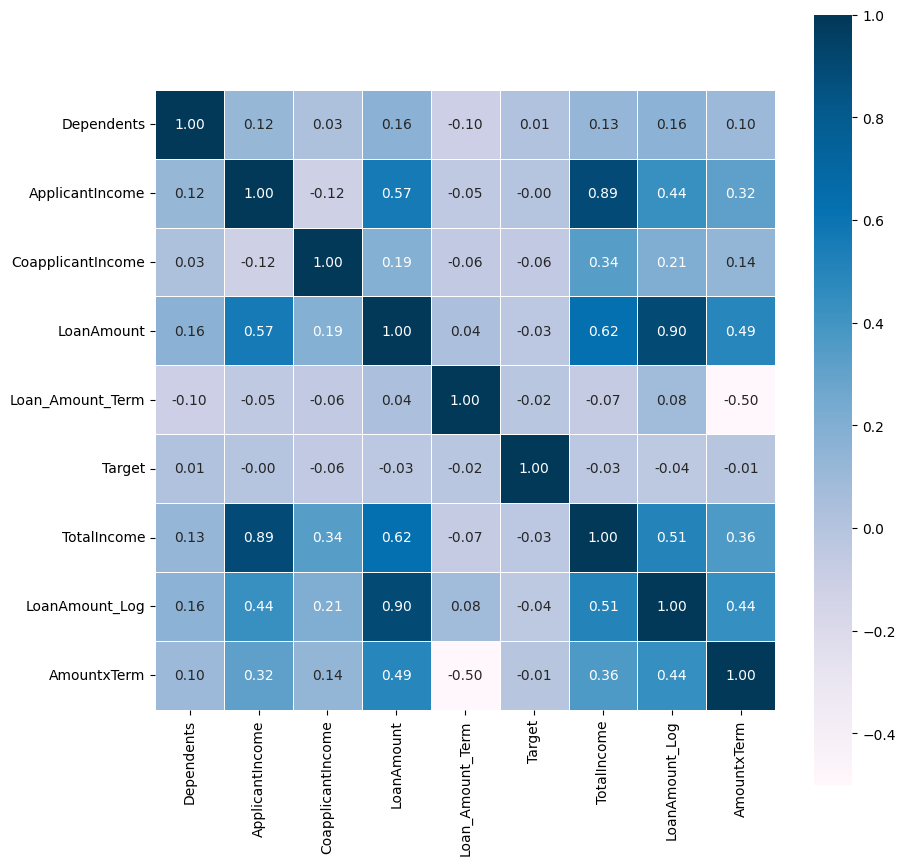

In [46]:
# Heatmap matriz de correlaciones
# ==============================================================================
corr = sns.heatmap(corr_matrix,
                   vmax = 1,
                   square = True,
                   linewidth = 0.5,
                   yticklabels = True,
                   xticklabels = True,
            cbar_kws = {'shrink' : 1},
                   annot = True,
                   fmt = '.2f',
                   cmap = 'PuBu')
corr.figure.set_size_inches(10,10)


In [47]:
# Eliminamos variables por alta correlación
preprocessed_data = preprocessed_data.drop(['ApplicantIncome','LoanAmount'], axis = 1)

Definición de variables: Independientes y Dependiente

In [48]:
# Dividiendo la data
X = preprocessed_data.drop(['Target'], axis = 1)

In [49]:
y= preprocessed_data.Target

In [50]:
numericas = X.select_dtypes(include=('int64','float64')).columns.tolist()
numericas

['Dependents',
 'CoapplicantIncome',
 'Loan_Amount_Term',
 'TotalIncome',
 'LoanAmount_Log',
 'AmountxTerm']

In [51]:
scaler = StandardScaler()
numerical = X[numericas]
numerical = pd.DataFrame(scaler.fit_transform(numerical),
                         columns=['Dependents','CoapplicantIncome','Loan_Amount_Term','TotalIncome','LoanAmount_Log',
                                  'AmountxTerm'],index= numerical.index)

In [52]:
preprocessed_data = pd.merge(numerical, categorical, left_index=True, right_index=True)
preprocessed_data.head()

,Dependents,CoapplicantIncome,Loan_Amount_Term,TotalIncome,LoanAmount_Log,AmountxTerm,Gender,Married,Education,Credit_History,Property_Area_1,Property_Area_2
0,-0.737806,-0.554487,0.273231,-0.182184,-0.012579,-0.222965,True,False,False,True,False,True
1,0.253470,-0.038732,0.273231,-0.144684,-0.012579,-0.222965,True,True,False,True,False,False
2,-0.737806,-0.554487,0.273231,-0.623656,-1.357595,-0.575498,True,True,False,True,False,True
3,-0.737806,0.251980,0.273231,-0.322885,-0.134853,-0.281720,True,True,True,True,False,True
4,-0.737806,-0.554487,0.273231,-0.158785,0.191211,-0.164209,True,False,False,True,False,True


# Regresión Logística

In [53]:
# División de los datos en train y testRegresión Logística
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data,y,train_size = 0.8,test_size=0.20,random_state = 20,stratify = y)

In [54]:
rl = LogisticRegression(max_iter = 250, # Número máximo de iteraciones
                        C = 0.5,        # Inverso de la fuerza de regularización
                        penalty='l2',   # Penalización admitida L2
                        solver = 'lbfgs')

In [55]:
# Entrenamiento del modelo
rl.fit(X_train, y_train)

LogisticRegression(C=0.5, max_iter=250)

In [56]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=rl.predict(X_train) # Prediccion sobre el train
y_pred_test=rl.predict(X_test) # Prediccion sobre el test

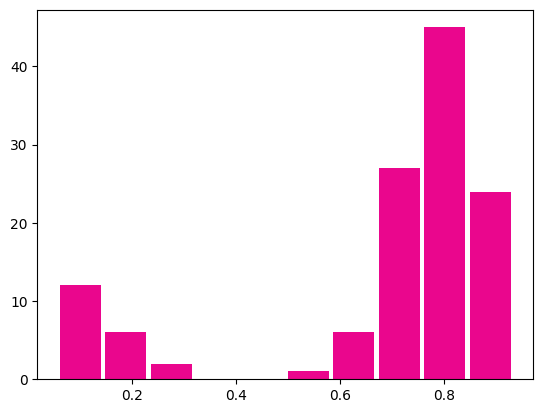

In [57]:
# Calculando probabilidades del modelo
prob_test_rl = rl.predict_proba(X_test)[:,1]
plt.hist(prob_test_rl, color = '#ea068d', rwidth=0.9)
plt.savefig('Probabilidades_test_rl.png', bbox_inches='tight')

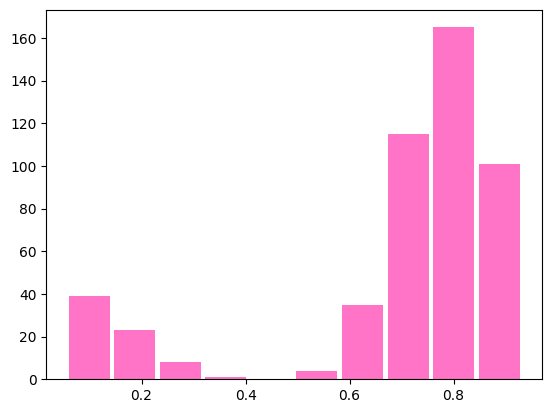

In [58]:
# Calculando las probabilidades para la muestra de entrenamiento
prob_train_rl = rl.predict_proba(X_train)[:,1]
plt.hist(prob_train_rl, color = '#ff74c6', rwidth=0.9)
plt.savefig('Probabilidades_train_rl.png', bbox_inches='tight')

Evaluación del Modelo

Matriz de Confusión

In [59]:
## Funciones
def print_mc(matriz_conf):
    matriz_conf = pd.DataFrame(matriz_conf)
    matriz_conf.index = ["Real_0","Real_1"]
    matriz_conf.columns = ["Pred_0","Pred_1"]
    print(matriz_conf)

def fx_evaluate_classif(y_real, pred, pred_proba):
    from sklearn import metrics as mt
    matriz_conf = mt.confusion_matrix(y_real,pred)
    print_mc(matriz_conf)
    roc = mt.roc_auc_score(y_real,pred_proba)
    accuracy_real = mt.accuracy_score(y_real,pred)
    print("\nROC: ", roc)
    print("Accu:", accuracy_real,'\n')
    print(mt.classification_report(y_real, pred)[0:163])

In [60]:
print("Metricas del Testing..." + "\n")
fx_evaluate_classif(y_test, y_pred_test, prob_test_rl)

Metricas del Testing...

        Pred_0  Pred_1
Real_0      17      21
Real_1       3      82

ROC:  0.734984520123839
Accu: 0.8048780487804879 

              precision    recall  f1-score   support

           0       0.85      0.45      0.59        38
           1       0.80      0.96      0.87        85



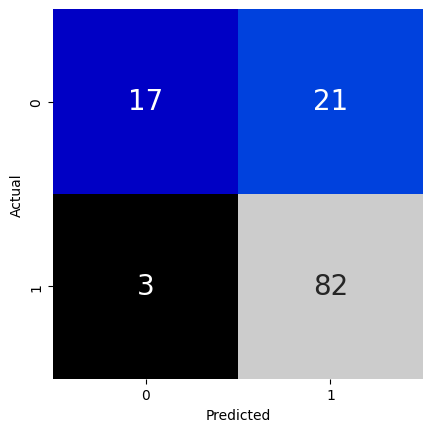

In [61]:
mat_logreg = confusion_matrix(y_test, y_pred_test)
sns.heatmap(mat_logreg, annot=True, fmt='d',cmap='nipy_spectral', square=True, cbar=False, annot_kws = {'size' : 20})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Confusion_matrix_rl.png', bbox_inches='tight')

Curva de ROC

In [62]:
## AUC: Area bajo la curva
auc_rl = metrics.roc_auc_score(y_test, prob_test_rl)
auc_rl

0.734984520123839

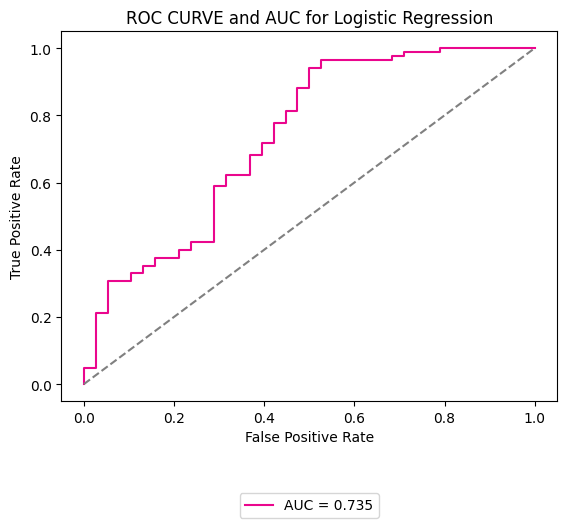

In [63]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, prob_test_rl)
plt.plot(fpr, tpr, label= "AUC = " + str(auc_rl.round(3)), color='#ea068d')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC CURVE and AUC for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(.5,-0.23), loc='upper center')
plt.savefig('ROC_CURVES_rl.png', bbox_inches='tight')

Resultados del Modelo

In [64]:
# Asignamos las probabilidades a los Resultados del Modelodatos transformados
probabilidad = list(prob_test_rl.round(3))
probabilidad_train = list(prob_train_rl.round(3))
X_test['PROBABILIDAD'] = probabilidad
X_train['PROBABILIDAD'] = probabilidad_train

In [65]:
# Ordenamos de mayor a menor las probabilidades
X_train = X_train.sort_values(['PROBABILIDAD'], ascending=False)
X_test = X_test.sort_values(['PROBABILIDAD'], ascending=False)

In [66]:
# Creamos grupos de probabilidad para la muestra de entrenamiento
X_train['GRUPOS'] = pd.qcut(X_train['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [67]:
# Creamos grupos de probabilidad para la muestra de validación
X_test['GRUPOS'] = pd.qcut(X_test['PROBABILIDAD'], 10, labels=[10,9,8,7,6,5,4,3,2,1])

In [68]:
# Añadimos los identificadores de clientes
final_train = X_train.merge(df_index, how='left', left_index=True, right_index=True, sort=False)
final_test = X_test.merge(df_index, how='left', left_index=True, right_index=True, sort=False)

In [69]:
# Creamos una tabla resumen para la muestra de entrenamiento, donde debe mostrarse:
# - La distribución por grupos del modelo
# - La probabilidad mínima, media y máxima de cada grupo
# - Comparamos con la respuesta real de la muestra
resumen_train = final_train.groupby('GRUPOS')['PROBABILIDAD'].agg(['count','min','max','mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
ventas_train = final_train.groupby('GRUPOS')['Target'].agg(['sum', 'min', 'max', 'mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
resumen_train = pd.merge(resumen_train, ventas_train[['sum','mean']], left_index=True, right_index=True)
resumen_train.rename(columns={'count' : 'Leads', 'min' : 'Min', 'max': 'Max', 'sum': 'Préstamo', 'mean_x' : '%RR (Estimado)', 'mean_y' : '%RR (Real)'}, inplace = True)
#resumen_train.to_excel(path_file + '\Resultados_train_RegLog.xlsx', index = False)
resumen_train.to_excel('Resultados_train_rl.xlsx', index = False)
resumen_train

,GRUPOS,Leads,Min,Max,%RR (Estimado),Préstamo,%RR (Real)
9,1,48,0.876,0.931,0.889833,46,0.958333
8,2,49,0.848,0.875,0.863490,43,0.877551
7,3,50,0.815,0.847,0.831560,42,0.840000
6,4,48,0.791,0.814,0.801312,38,0.791667
5,5,48,0.767,0.790,0.778896,40,0.833333
4,6,51,0.735,0.765,0.752686,34,0.666667
3,7,47,0.701,0.732,0.713532,37,0.787234
2,8,51,0.655,0.700,0.680627,37,0.725490
1,9,49,0.177,0.652,0.450653,17,0.346939
0,10,50,0.056,0.176,0.116600,3,0.060000


In [70]:
# Creamos una tabla resumen para la muestra de validación, donde debe mostrarse:
# - La distribución por grupos del modelo
# - La probabilidad mínima, media y máxima de cada grupo
# - Comparamos con la respuesta real de la muestra
resumen_test = final_test.groupby('GRUPOS')['PROBABILIDAD'].agg(['count','min','max','mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
ventas_test = final_test.groupby('GRUPOS')['Target'].agg(['sum', 'min', 'max', 'mean']).reset_index().sort_values(['GRUPOS'], ascending=False)
resumen_test = pd.merge(resumen_test, ventas_test[['sum','mean']], left_index=True, right_index=True)
resumen_test.rename(columns={'count' : 'Leads', 'min' : 'Min', 'max': 'Max', 'sum': 'Préstamo', 'mean_x' : '%RR (Estimado)', 'mean_y' : '%RR (Real)'}, inplace = True)
#resumen_test.to_excel(path_file + '\Resultados_test_RegLog.xlsx', index = False)
resumen_test.to_excel('Resultados_test_rl.xlsx', index = False)
resumen_test

,GRUPOS,Leads,Min,Max,%RR (Estimado),Préstamo,%RR (Real)
9,1,12,0.877,0.933,0.896667,11,0.916667
8,2,13,0.843,0.876,0.863308,12,0.923077
7,3,12,0.828,0.839,0.835167,8,0.666667
6,4,12,0.809,0.827,0.816917,7,0.583333
5,5,12,0.780,0.802,0.791667,12,1.000000
4,6,13,0.739,0.776,0.761462,9,0.692308
3,7,12,0.707,0.736,0.721083,10,0.833333
2,8,12,0.647,0.705,0.684500,10,0.833333
1,9,12,0.162,0.642,0.368250,4,0.333333
0,10,13,0.057,0.152,0.120154,2,0.153846
